In [1]:
import os
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

CONFIG = {
    "input_len": 30,
    "output_len": 1,
    "total_predict_days": 100,
    "batch_size": 32,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "num_epochs": 80,
    "early_stop_patience": 15,
    "val_size": 120,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

print("Device:", CONFIG["device"])

Device: cpu


In [2]:
def load_fpt_data():
    """Tự tìm file FPT_train.csv trong data/raw, kể cả khi notebook nằm trong notebooks/."""
    cwd = Path.cwd()

    # Thử 2 vị trí chuẩn:
    # 1) Chạy từ root project: data/raw/FPT_train.csv
    # 2) Chạy từ thư mục notebooks: ../data/raw/FPT_train.csv
    candidates = [
        cwd / "data" / "raw" / "FPT_train.csv",
        cwd.parent / "data" / "raw" / "FPT_train.csv",
    ]

    path = None
    for p in candidates:
        if p.exists():
            path = p
            break

    # Fallback: rglob từ root project (thư mục cha của notebooks)
    if path is None:
        project_root = cwd.parent
        found = list(project_root.rglob("FPT_train.csv"))
        if not found:
            raise FileNotFoundError("Không tìm thấy FPT_train.csv trong project")
        path = found[0]

    print("Reading:", path)
    return pd.read_csv(path)


df = load_fpt_data()
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").reset_index(drop=True)

print(df.head())
print("Date range:", df.time.min(), "->", df.time.max())
print("N =", len(df))


Reading: d:\LearingWithBitznomad\AI\AI-VietNam\VietAI-Learning-Module6\data\raw\FPT_train.csv
        time   open   high    low  close   volume symbol
0 2020-08-03  19.07  19.63  19.03  19.63  1392200    FPT
1 2020-08-04  19.89  20.01  19.76  19.91  1051310    FPT
2 2020-08-05  19.89  20.16  19.78  20.10  1328520    FPT
3 2020-08-06  20.10  20.21  19.97  20.01  1153660    FPT
4 2020-08-07  20.01  20.44  20.01  20.14  1283690    FPT
Date range: 2020-08-03 00:00:00 -> 2025-03-10 00:00:00
N = 1149


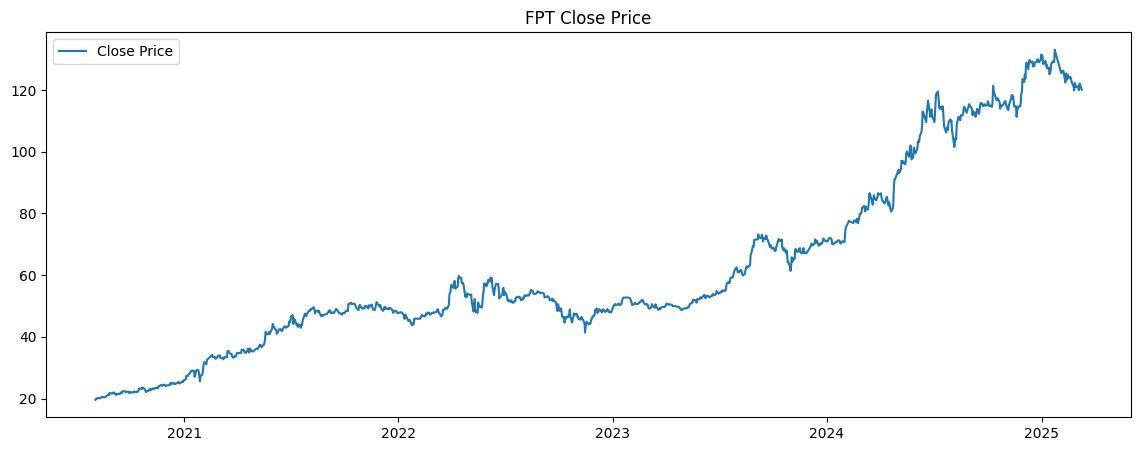

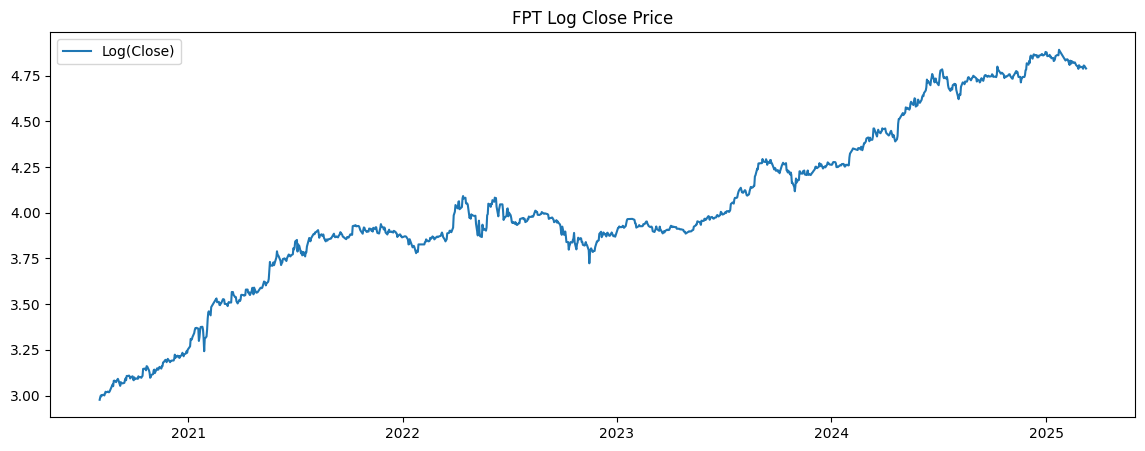

,time,close,close_log
1144,2025-03-04,120.71,4.793391
1145,2025-03-05,119.93,4.786908
1146,2025-03-06,122.09,4.804758
1147,2025-03-07,121.92,4.803365
1148,2025-03-10,120.11,4.788408


In [3]:
df["close_log"] = np.log(df["close"])

plt.figure(figsize=(14,5))
plt.plot(df["time"], df["close"], label="Close Price")
plt.title("FPT Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(df["time"], df["close_log"], label="Log(Close)")
plt.title("FPT Log Close Price")
plt.legend()
plt.show()

df = df[["time", "close", "close_log"]].dropna().reset_index(drop=True)
df.tail()


In [4]:
input_len = CONFIG["input_len"]
output_len = CONFIG["output_len"]
val_size = CONFIG["val_size"]

val_window_len = val_size + input_len + output_len - 1
df_train = df.iloc[:-val_window_len].reset_index(drop=True)
df_val   = df.iloc[-val_window_len:].reset_index(drop=True)

print("Train:", df_train.shape, "Val:", df_val.shape)

feature_cols = ["close_log"]
target_col = "close_log"

class TimeSeriesDataset(Dataset):
    def __init__(self, data, feature_cols, input_len, output_len,
                 target_col="close_log", scaler=None, fit_scaler=False):

        self.input_len = input_len
        self.output_len = output_len
        self.feature_cols = feature_cols
        self.target_col = target_col

        X = data[feature_cols].values.astype(np.float32)
        y = data[target_col].values.astype(np.float32)

        if fit_scaler:
            self.scaler = StandardScaler()
            X = self.scaler.fit_transform(X)
        else:
            self.scaler = scaler
            X = self.scaler.transform(X)

        X_seq, y_seq = [], []
        for i in range(len(data) - input_len - output_len + 1):
            X_seq.append(X[i:i+input_len])
            y_seq.append(y[i+input_len:i+input_len+output_len])

        self.X_seq = np.array(X_seq)
        self.y_seq = np.array(y_seq)

    def __len__(self):
        return len(self.X_seq)

    def __getitem__(self, idx):
        return torch.tensor(self.X_seq[idx]), torch.tensor(self.y_seq[idx])

train_ds = TimeSeriesDataset(df_train, feature_cols, input_len, output_len, scaler=None, fit_scaler=True)
val_ds   = TimeSeriesDataset(df_val,   feature_cols, input_len, output_len, scaler=train_ds.scaler)

train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

Train: (999, 3) Val: (150, 3)
Train samples: 969 Val samples: 120


In [5]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden, layers, dropout, output_len):
        super().__init__()
        self.gru = nn.GRU(
            input_size, hidden, layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden, output_len)

    def forward(self, x):
        out,_ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = GRUModel(
    input_size=len(feature_cols),
    hidden=CONFIG["hidden_size"],
    layers=CONFIG["num_layers"],
    dropout=CONFIG["dropout"],
    output_len=output_len
).to(CONFIG["device"])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])

In [6]:
best_loss = 9999
patience = CONFIG["early_stop_patience"]
no_up = 0
device = CONFIG["device"]

for epoch in range(CONFIG["num_epochs"]):
    model.train()
    tl = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        pred = model(xb).squeeze()
        yb = yb.squeeze()

        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        tl.append(loss.item())

    model.eval()
    vl = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).squeeze(); yb = yb.squeeze()
            vl.append(criterion(pred, yb).item())

    tl, vl = np.mean(tl), np.mean(vl)
    print(f"Epoch {epoch:03d} | Train {tl:.6f} | Val {vl:.6f}")

    if vl < best_loss:
        best_loss = vl
        best_state = model.state_dict()
        no_up = 0
    else:
        no_up += 1
        if no_up >= patience:
            print("Early stopping!")
            break

model.load_state_dict(best_state)


Epoch 000 | Train 6.878038 | Val 0.005517
Epoch 001 | Train 0.181696 | Val 0.568652
Epoch 002 | Train 0.035795 | Val 0.332409
Epoch 003 | Train 0.027918 | Val 0.286852
Epoch 004 | Train 0.021811 | Val 0.228779
Epoch 005 | Train 0.017799 | Val 0.192053
Epoch 006 | Train 0.013994 | Val 0.147851
Epoch 007 | Train 0.011202 | Val 0.116173
Epoch 008 | Train 0.008578 | Val 0.094835
Epoch 009 | Train 0.006730 | Val 0.071970
Epoch 010 | Train 0.005280 | Val 0.052129
Epoch 011 | Train 0.004003 | Val 0.039333
Epoch 012 | Train 0.003223 | Val 0.029091
Epoch 013 | Train 0.002826 | Val 0.022827
Epoch 014 | Train 0.002467 | Val 0.016939
Epoch 015 | Train 0.002093 | Val 0.010874
Early stopping!


<All keys matched successfully>

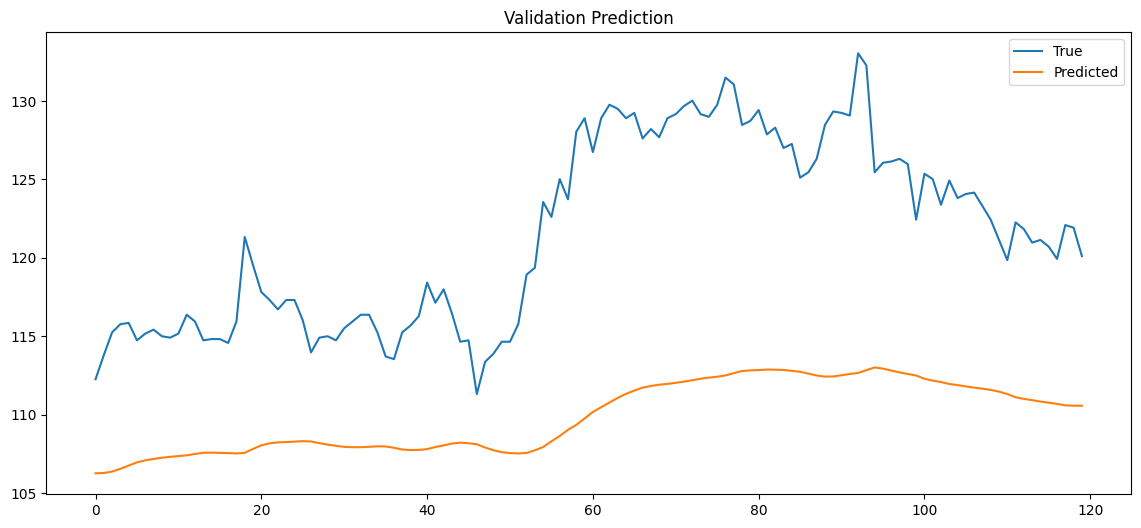

Validation MAPE:  9.43195


In [7]:
model.eval()
preds_log = []
true_log = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb).squeeze().cpu().numpy()
        true = yb.squeeze().numpy()
        preds_log.append(pred)
        true_log.append(true)

preds_log = np.concatenate(preds_log)
true_log = np.concatenate(true_log)

preds = np.exp(preds_log)
true  = np.exp(true_log)

plt.figure(figsize=(14,6))
plt.plot(true, label="True")
plt.plot(preds, label="Predicted")
plt.title("Validation Prediction")
plt.legend()
plt.show()

mape = np.mean(np.abs((true - preds) / true)) * 100
print("Validation MAPE: ", mape)


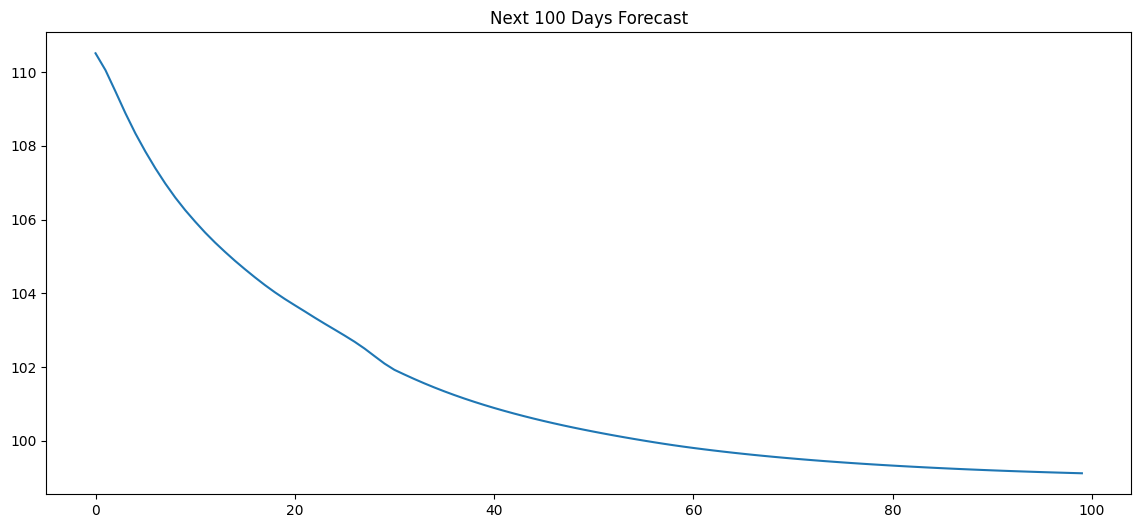

In [8]:
history = df["close_log"].tolist()
model.eval()
pred_close = []

for day in range(CONFIG["total_predict_days"]):
    window = np.array(history[-input_len:]).reshape(-1,1)
    window_scaled = train_ds.scaler.transform(window)

    x = torch.tensor(window_scaled, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_log = model(x).item()

    last_close = math.exp(history[-1])
    new_close = math.exp(pred_log)

    # CLIP -> không nổ giá
    new_close = float(np.clip(new_close, 0.8*last_close, 1.25*last_close))

    pred_close.append(new_close)
    history.append(math.log(new_close))

plt.figure(figsize=(14,6))
plt.plot(pred_close)
plt.title("Next 100 Days Forecast")
plt.show()

In [9]:
sub = pd.DataFrame({
    "id": range(1, 101),
    "close": pred_close
})

output_filename = 'submission.csv'
sub.to_csv(output_filename, index=False)
print(f"Đã lưu file: {output_filename}")

Đã lưu file: submission.csv
